In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from src.utils.datasets.ggimages import OpenImage
from src.utils.datasets.transform import RandomHorizontalFlip, Resize, Compose, XyToCenter
import torchvision.transforms as transforms
from src.utils.display.images import imshow, result_show
from torch.utils.data import DataLoader
from src.utils.datasets.adapter import convert_data
import numpy as np
from src.network.yolo import Yolo
from src.config import VOC_ANCHORS
from src.utils.process_boxes import preprocess_true_boxes


general_transform = Compose([
    Resize((128, 128)),
    XyToCenter()
])


transform = transforms.Compose([
                transforms.RandomChoice([
                    transforms.ColorJitter(hue=.1, saturation=.1),
                    transforms.RandomGrayscale(p=0.7),
                ]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])

In [3]:
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from src.utils.evaluate.metter import AverageMeter

In [4]:
batch_size = 1

ds = OpenImage('/data/data', 'OpenImage', general_transform=general_transform, transform=transform)

train_data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=convert_data, num_workers=0)


In [5]:
from src.network.base import DarkNet, DarknetBody, YoloBody

model = Yolo(VOC_ANCHORS, ds.classes)
# model.cuda()
model.train()

Yolo(
  (yolo_body): YoloBody(
    (body_bottom): DarknetBodyBottom(
      (first_layer): Conv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1)
      )
      (second_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (third_layer): Conv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1)
      )
      (forth_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fifth_layer): BottleneckBlock(
        (first_layer): Conv2d(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, ep

In [ ]:
params = filter(lambda x: x.requires_grad, model.parameters())
optimizer = SGD(model.parameters(), lr = 0.01, momentum=0.9)
# optimizer = RMSprop(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=0.00005)?
exp_lr_scheduler = StepLR(optimizer, step_size=5000, gamma=0.99)

In [ ]:
def train(data_gen ,model, metters, optimizer, lr_scheduler, current_epoch=0):
    
    steps_per_epoch = len(data_gen) 
    model.train()
    train_loss = metters
    for step, blobs in enumerate(data_gen):
        batch_tensor, batch_boxes, detectors_mask, matching_true_boxes, im_info, img_name = blobs
#         batch_tensor = batch_tensor.to(torch.device('cuda'))
#         detectors_mask = detectors_mask.to(torch.device('cuda'))
#         matching_true_boxes = matching_true_boxes.to(torch.device('cuda'))
#         batch_boxes = batch_boxes.to(torch.device('cuda'))

        output = model(batch_tensor)
        loss = model.loss(output, batch_boxes, detectors_mask, matching_true_boxes)
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        train_loss.update(loss.item())     

        current_step = current_epoch * steps_per_epoch + step
        if step % 2 == 1:
            log_text = 'epoch: %d : step %d,  loss: %.4f at %s' % (
                current_epoch + 1, step , train_loss.avg, datetime.now().strftime('%m/%d_%H:%M'))
            print(log_text)


In [ ]:
train_loss = AverageMeter()
train(train_data_loader ,model, train_loss, optimizer, exp_lr_scheduler, 1)


torch.Size([1, 3, 128, 128])
torch.Size([1, 2, 1, 4, 4])


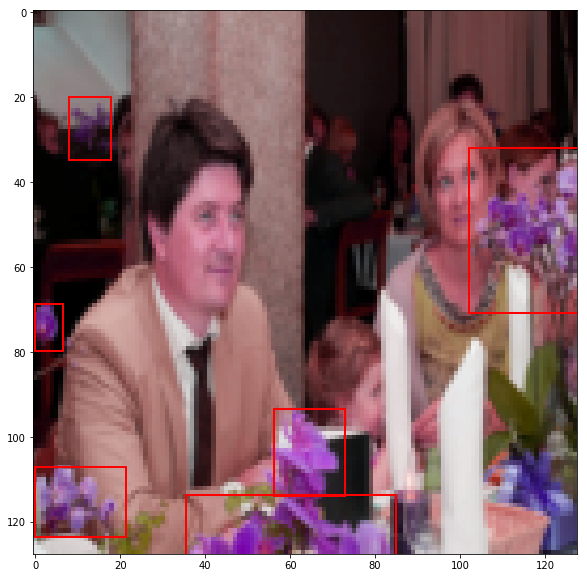

In [53]:
data = next(iter(train_data_loader))
batch_tensor, batch_boxes, detectors_mask, matching_true_boxes, im_info, img_name = data
# batch_tensor, im_info, batch_boxes, batch_boxes_index, img_name = data

from src.utils.display.images import imshow, result_show
for k in range(batch_tensor.shape[0]):
    current_im_info = im_info[k]
    tmp = batch_boxes[k] * torch.Tensor([current_im_info[0], current_im_info[1], current_im_info[0], current_im_info[1], 1])
    tmp = tmp.numpy()        
    between = tmp[:, 2:4] / 2        
    xy = tmp[:, :2]
    xy_min = xy - between
    xy_max = xy + between
    print(np.hstack((xy_min, xy_max)))
    imshow(batch_tensor[k], gt_boxes=np.hstack((xy_min, xy_max)))

In [67]:
output = model(batch_tensor)
print(batch_boxes)
print(detectors_mask.shape)
print(detectors_mask)
print(matching_true_boxes.shape)

tensor([[[0.0259, 0.5798, 0.0518, 0.0849, 2.0000],
         [0.0830, 0.9004, 0.1660, 0.1288, 2.0000],
         [0.1011, 0.2145, 0.0771, 0.1157, 2.0000],
         [0.4702, 0.9429, 0.3877, 0.1113, 2.0000],
         [0.5044, 0.8097, 0.1318, 0.1611, 2.0000],
         [0.8979, 0.4019, 0.2021, 0.3031, 2.0000]]])
torch.Size([1, 2, 1, 4, 4])
tensor([[[[[0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.]]],


         [[[1., 0., 0., 0.],
           [0., 0., 0., 1.],
           [1., 0., 0., 0.],
           [1., 1., 1., 0.]]]]])
torch.Size([1, 2, 7, 4, 4])


In [77]:
loss = model.loss(output, batch_boxes, detectors_mask, matching_true_boxes)

tensor([[[[[0.0055, 0.0049, 0.0053, 0.0052],
           [0.0054, 0.0051, 0.0052, 0.0056],
           [0.0055, 0.0050, 0.0057, 0.0055],
           [0.0058, 0.0053, 0.0057, 0.0057]],

          [[0.0225, 0.0219, 0.0223, 0.0222],
           [0.0224, 0.0221, 0.0222, 0.0226],
           [0.0225, 0.0220, 0.0227, 0.0225],
           [0.0228, 0.0223, 0.0227, 0.0226]],

          [[0.0100, 0.0094, 0.0098, 0.0098],
           [0.0099, 0.0097, 0.0097, 0.0101],
           [0.0100, 0.0096, 0.0102, 0.0100],
           [0.0103, 0.0098, 0.0103, 0.0102]],

          [[0.0442, 0.0436, 0.0440, 0.0440],
           [0.0442, 0.0439, 0.0439, 0.0444],
           [0.0443, 0.0438, 0.0444, 0.0442],
           [0.0446, 0.0440, 0.0445, 0.0443]],

          [[0.0223, 0.0217, 0.0221, 0.0221],
           [0.0222, 0.0220, 0.0220, 0.0224],
           [0.0224, 0.0219, 0.0225, 0.0223],
           [0.0226, 0.0221, 0.0226, 0.0225]],

          [[0.0623, 0.0617, 0.0622, 0.0621],
           [0.0623, 0.0620, 0.0620, 0.0625],


In [10]:
print(loss)

tensor(6476076.5000, grad_fn=<DivBackward0>)
